In [1]:
#get rid of annoying GPU warnings (and others)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.svm import SVC
import sklearn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.models import Sequential, model_from_json  # Model type to be used
from keras.optimizers import Adam

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
from pathlib import Path


In [3]:
def load_image_files(container_path, dimension=(128,128)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "Your own dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            if file.suffix.lower() not in ['.jpg', '.jpeg', '.png','.webp','.gif']:
                print(f"Skipped non-image file: {file}")
                continue
            img = cv2.imread(str(file), cv2.IMREAD_COLOR)
            if img is None:
                print(f"Failed to read image: {file}")
                continue
            img_resized = cv2.resize(img, dimension, interpolation=cv2.INTER_AREA)
            
            if img_resized.size == 0:
                print(f"Empty image: {file}")
                continue
            flat_data.append(img_resized.flatten())
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)


    return Bunch(
        data=flat_data,
        target=target,
        target_names=categories,
        images=images,
        DESCR=descr
    )

In [4]:
image_dataset = load_image_files("/kaggle/input/soil-data-v3/Soil_Data_V3/Trains")
image_dataset_test = load_image_files("/kaggle/input/soil-data-v3/Soil_Data_V3/Tests")

Skipped non-image file: /kaggle/input/soil-data-v3/Soil_Data_V3/Trains/Mary/desktop.ini
Skipped non-image file: /kaggle/input/soil-data-v3/Soil_Data_V3/Trains/Sand/desktop.ini
Skipped non-image file: /kaggle/input/soil-data-v3/Soil_Data_V3/Trains/Silt/desktop.ini
Skipped non-image file: /kaggle/input/soil-data-v3/Soil_Data_V3/Tests/Chalky/desktop.ini


In [5]:
accuracy = []
f1_score = []
precision_score = []
recall_score = []

In [6]:
X_train = image_dataset.images.reshape(-1,128*128*3)
X_test = image_dataset_test.images.reshape(-1,128*128*3)
y_train = image_dataset.target
y_test=image_dataset_test.target

In [7]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess test dataset

test_features = X_test


# Load and preprocess train dataset

train_features = X_train


# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

# Perform PCA
pca = PCA(n_components = 200)
X_train = pca.fit_transform(scaled_train_features, y_train)
X_test = pca.transform(scaled_test_features)

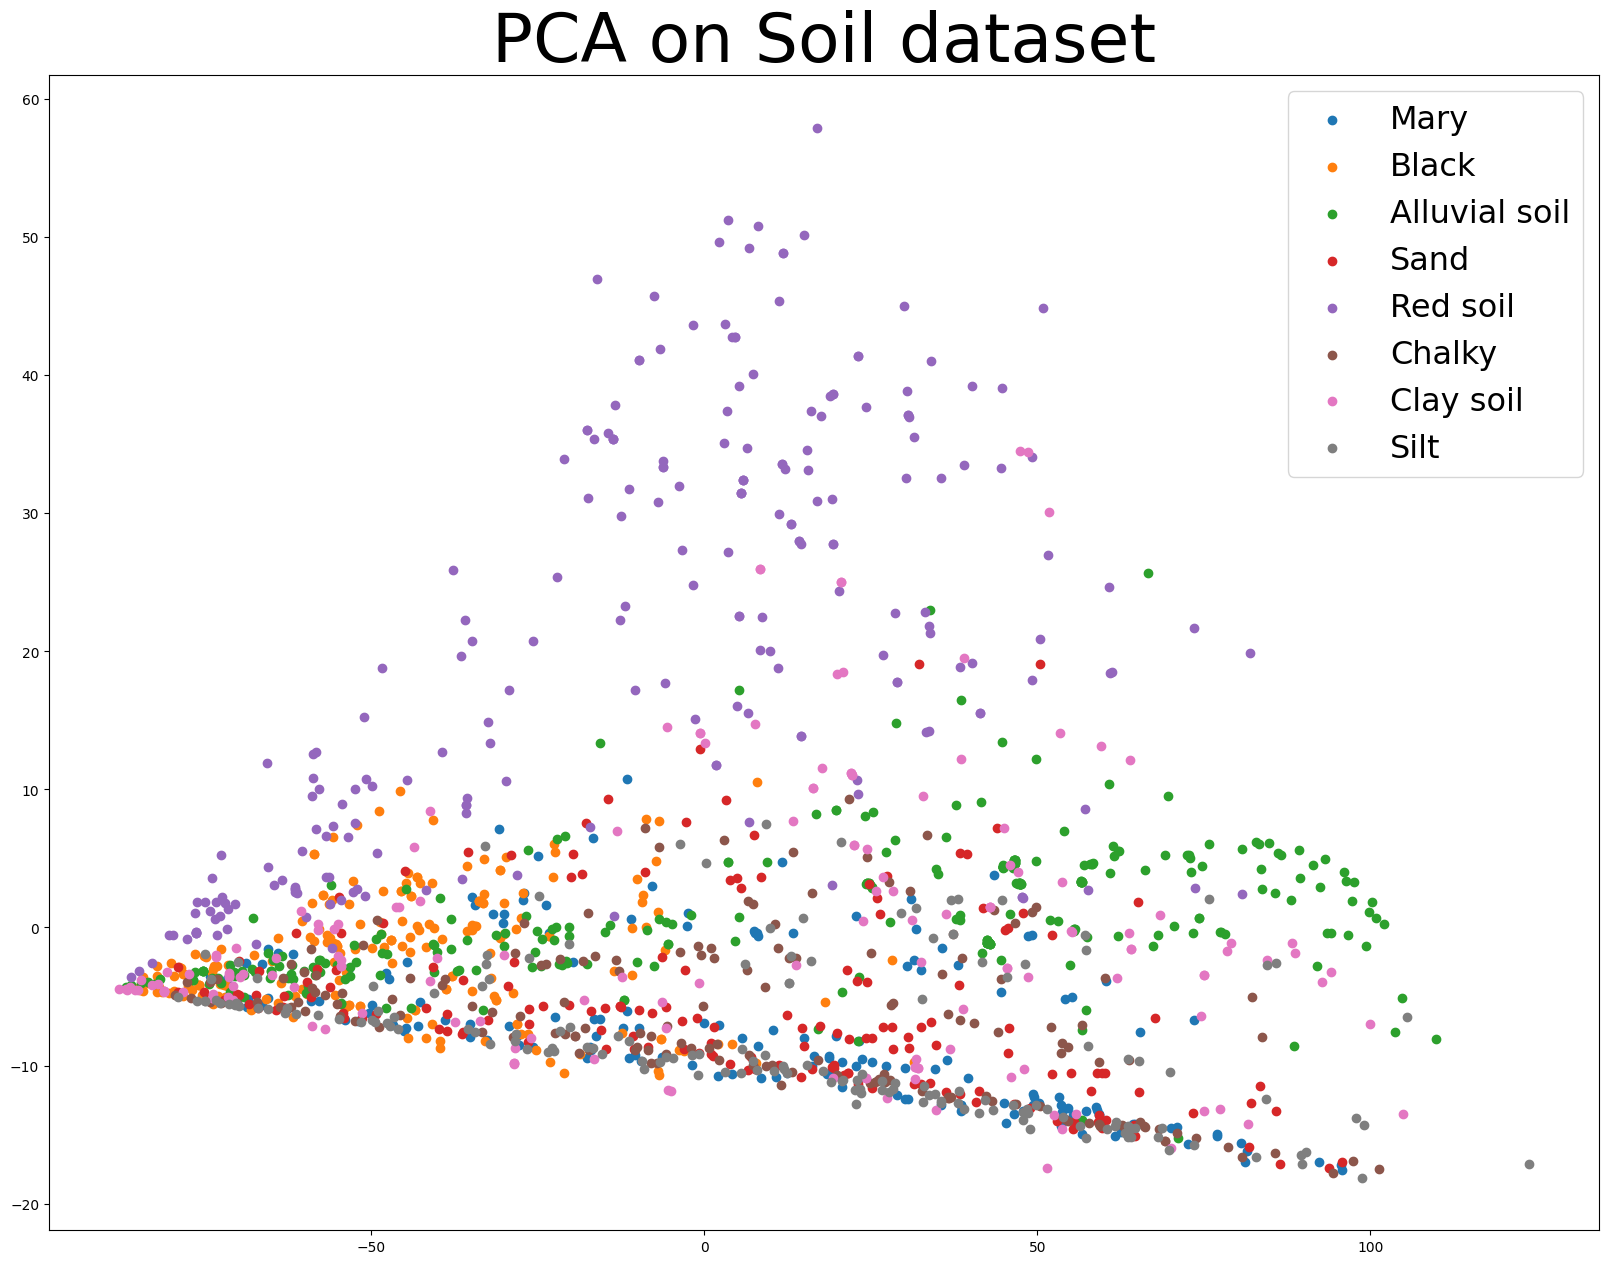

In [8]:
plt.figure(figsize=(20,15))
for  i, target_name in zip([ 0, 1, 2, 3, 4, 5, 6, 7], image_dataset.target_names):
    plt.scatter(X_test[y_test == i, 0], X_test[y_test== i, 1], label=target_name)
plt.legend(fontsize=23)
plt.title('PCA on Soil dataset', fontsize =49)

plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier
import time

# Start timing
start_time = time.time()
clf_rf = RandomForestClassifier(class_weight='balanced',max_depth= 9, min_samples_leaf= 3, min_samples_split= 2, random_state=42)

clf_rf.fit(X_train,y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy_rf = metrics.accuracy_score(y_test, y_pred_rf)
f1_rf = metrics.f1_score(y_test, y_pred_rf, average='weighted')
precision_rf = metrics.precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = metrics.recall_score(y_test, y_pred_rf, average='weighted')
print(metrics.classification_report(y_test, y_pred_rf, target_names=image_dataset.target_names))
print("Accuracy", round(accuracy_rf*100,2))

print("F1-score ",round(f1_rf*100,2))
print("Precision ",round(precision_rf*100,2))
print("Recall",round(recall_rf*100,2))

accuracy.append(round(accuracy_rf*100,2))
f1_score.append(round(f1_rf*100,2))


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time:", round(elapsed_time, 2), "seconds")

               precision    recall  f1-score   support

         Mary       0.89      0.76      0.82       172
        Black       0.51      0.95      0.66       210
Alluvial soil       0.90      0.84      0.87       316
         Sand       0.81      0.59      0.68       170
     Red soil       0.88      0.84      0.86       222
       Chalky       0.71      0.70      0.71       166
    Clay soil       0.83      0.60      0.70       160
         Silt       0.76      0.61      0.68       168

     accuracy                           0.76      1584
    macro avg       0.78      0.74      0.75      1584
 weighted avg       0.79      0.76      0.76      1584

Accuracy 75.51
F1-score  75.92
Precision  79.15
Recall 75.51
Elapsed Time: 3.08 seconds


In [10]:
from sklearn.tree import DecisionTreeClassifier
start_time = time.time()
clf_dt = DecisionTreeClassifier(class_weight='balanced',max_depth =9, min_samples_leaf=1, min_samples_split= 2, random_state=42)

clf_dt.fit(X_train, y_train)

y_pred_dt = clf_dt.predict(X_test)
accuracy_dt = metrics.accuracy_score(y_test, y_pred_dt)
f1_dt = metrics.f1_score(y_test, y_pred_dt, average='weighted')
precision_dt = metrics.precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = metrics.recall_score(y_test, y_pred_dt, average='weighted')
print(metrics.classification_report(y_test, y_pred_dt, target_names=image_dataset.target_names))
print("Accuracy", round(accuracy_dt*100,2))

print("F1-score ",round(f1_dt*100,2))
print("Precision ",round(precision_dt*100,2))
print("Recall",round(recall_dt*100,2))

accuracy.append(round(accuracy_dt*100,2))
f1_score.append(round(f1_dt*100,2))

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time:", round(elapsed_time, 2), "seconds")

               precision    recall  f1-score   support

         Mary       0.68      0.44      0.53       172
        Black       0.61      0.65      0.63       210
Alluvial soil       0.86      0.73      0.79       316
         Sand       0.38      0.26      0.31       170
     Red soil       0.90      0.84      0.87       222
       Chalky       0.35      0.46      0.40       166
    Clay soil       0.60      0.52      0.56       160
         Silt       0.33      0.59      0.42       168

     accuracy                           0.59      1584
    macro avg       0.59      0.56      0.56      1584
 weighted avg       0.63      0.59      0.60      1584

Accuracy 58.84
F1-score  59.66
Precision  62.55
Recall 58.84
Elapsed Time: 0.67 seconds


In [11]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
kn = KNeighborsClassifier(n_neighbors=7)
kn.fit(X_train,y_train)

kn_pred = kn.predict(X_test)
print("----------------------------------")
print(metrics.classification_report(y_pred=kn_pred,y_true=y_test, target_names=image_dataset.target_names))
print("----------------------------------")
print("Accuracy = ", round(metrics.accuracy_score(kn_pred, y_test) *100,2))
print("----------------------------------")
print("F1-score = ", round(metrics.f1_score(kn_pred,y_test, average='weighted') * 100,2))

accuracy.append(round(metrics.accuracy_score(kn_pred, y_test) *100,2))
f1_score.append( round(metrics.f1_score(kn_pred,y_test, average='weighted') * 100,2))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time:", round(elapsed_time, 2), "seconds")

----------------------------------
               precision    recall  f1-score   support

         Mary       0.66      0.45      0.54       172
        Black       0.57      0.79      0.66       210
Alluvial soil       0.46      0.88      0.61       316
         Sand       0.45      0.38      0.41       170
     Red soil       0.89      0.84      0.87       222
       Chalky       0.37      0.25      0.30       166
    Clay soil       0.78      0.26      0.39       160
         Silt       0.80      0.23      0.36       168

     accuracy                           0.57      1584
    macro avg       0.62      0.51      0.52      1584
 weighted avg       0.61      0.57      0.54      1584

----------------------------------
Accuracy =  56.63
----------------------------------
F1-score =  59.1
Elapsed Time: 0.15 seconds


In [12]:
svm = SVC(class_weight='balanced', C=10,gamma='scale', kernel='linear', random_state=42) 
start_time = time.time()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=image_dataset.target_names))
accuracy_svm = metrics.accuracy_score(y_test, y_pred)
f1_svm = metrics.f1_score(y_test, y_pred, average='weighted')
precision_svm = metrics.precision_score(y_test, y_pred, average='weighted')
recall_svm = metrics.recall_score(y_test, y_pred, average='weighted')
print("Accuracy", accuracy_svm)
accuracy.append(accuracy_svm*100)
f1_score.append(f1_svm*100)
precision_score.append(precision_svm*100)
recall_score.append(recall_svm*100)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time:", round(elapsed_time, 2), "seconds")

accuracy.append(round(metrics.accuracy_score(y_test, y_pred) *100,2))
f1_score.append( round(metrics.f1_score(y_test, y_pred, average='weighted') * 100,2))

               precision    recall  f1-score   support

         Mary       0.86      0.73      0.79       172
        Black       0.86      0.92      0.89       210
Alluvial soil       0.81      0.89      0.85       316
         Sand       0.75      0.66      0.70       170
     Red soil       0.96      0.99      0.98       222
       Chalky       0.55      0.61      0.58       166
    Clay soil       0.78      0.68      0.72       160
         Silt       0.61      0.59      0.60       168

     accuracy                           0.78      1584
    macro avg       0.77      0.76      0.76      1584
 weighted avg       0.78      0.78      0.78      1584

Accuracy 0.7834595959595959
Elapsed Time: 4.3 seconds


[Text(0, 0.5, 'Mary'),
 Text(0, 1.5, 'Black'),
 Text(0, 2.5, 'Alluvial soil'),
 Text(0, 3.5, 'Sand'),
 Text(0, 4.5, 'Red soil'),
 Text(0, 5.5, 'Chalky'),
 Text(0, 6.5, 'Clay soil'),
 Text(0, 7.5, 'Silt')]

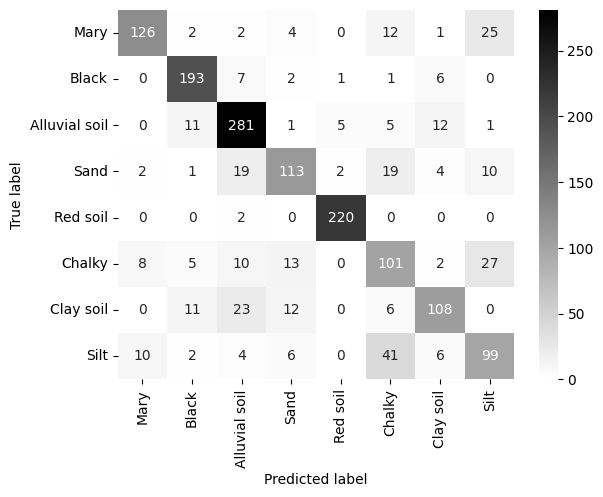

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt    


from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='binary')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(image_dataset.target_names, rotation='vertical')
ax.yaxis.set_ticklabels(image_dataset.target_names, rotation='horizontal')

In [14]:
X_train= image_dataset.images
X_test= image_dataset_test.images
y_train= image_dataset.target
y_test=image_dataset_test.target

print(X_train.shape)
print(X_test.shape) 

(3670, 128, 128, 3)
(1584, 128, 128, 3)


In [16]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model('/kaggle/input/trained-cnn/optimal_cnn.h5')

In [17]:
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=10,
                                        restore_best_weights=True)

In [18]:
history=loaded_model.fit(X_train,y_train,batch_size=8,epochs=30, validation_data=(X_test,y_test),verbose=1,callbacks=[earlystopping])

Epoch 1/30
459/459 [==============================] - 13s 11ms/step - loss: 0.0688 - accuracy: 0.9896 - val_loss: 0.8753 - val_accuracy: 0.8491
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0701 - accuracy: 0.9891 - val_loss: 0.7654 - val_accuracy: 0.8681
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0665 - accuracy: 0.9902 - val_loss: 0.8051 - val_accuracy: 0.8706
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0663 - accuracy: 0.9896 - val_loss: 0.6864 - val_accuracy: 0.8668
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0599 - accuracy: 0.9921 - val_loss: 0.7429 - val_accuracy: 0.8737
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0605 - accuracy: 0.9910 - val_loss: 0.7605 - val_accuracy: 0.8693
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0619 - accuracy: 0.9910 - val_loss: 0.6957 - val_accuracy: 0.872

In [19]:
y_pred = loaded_model.predict(X_test)
# Get the class predictions (indices of the highest probability) from y_pred
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test, y_pred, target_names=image_dataset.target_names))
accuracy_cnn = metrics.accuracy_score(y_test, y_pred)
f1_cnn = metrics.f1_score(y_test, y_pred, average='weighted')
precision_cnn = metrics.precision_score(y_test, y_pred, average='weighted')
recall_cnn = metrics.recall_score(y_test, y_pred, average='weighted')
print("Accuracy", accuracy_cnn * 100)
print("F1-Score", f1_cnn * 100)
accuracy.append(accuracy_cnn * 100)
f1_score.append(f1_cnn * 100)
precision_score.append(precision_cnn * 100)
recall_score.append(recall_cnn * 100)

50/50 [==============================] - 1s 7ms/step
               precision    recall  f1-score   support

         Mary       0.87      0.92      0.89       172
        Black       0.92      0.90      0.91       210
Alluvial soil       0.91      0.90      0.90       316
         Sand       0.92      0.76      0.83       170
     Red soil       0.89      1.00      0.94       222
       Chalky       0.79      0.79      0.79       166
    Clay soil       0.88      0.83      0.86       160
         Silt       0.73      0.78      0.75       168

     accuracy                           0.87      1584
    macro avg       0.86      0.86      0.86      1584
 weighted avg       0.87      0.87      0.87      1584

Accuracy 86.86868686868688
F1-Score 86.81239103370424


[Text(0, 0.5, 'Mary'),
 Text(0, 1.5, 'Black'),
 Text(0, 2.5, 'Alluvial soil'),
 Text(0, 3.5, 'Sand'),
 Text(0, 4.5, 'Red soil'),
 Text(0, 5.5, 'Chalky'),
 Text(0, 6.5, 'Clay soil'),
 Text(0, 7.5, 'Silt')]

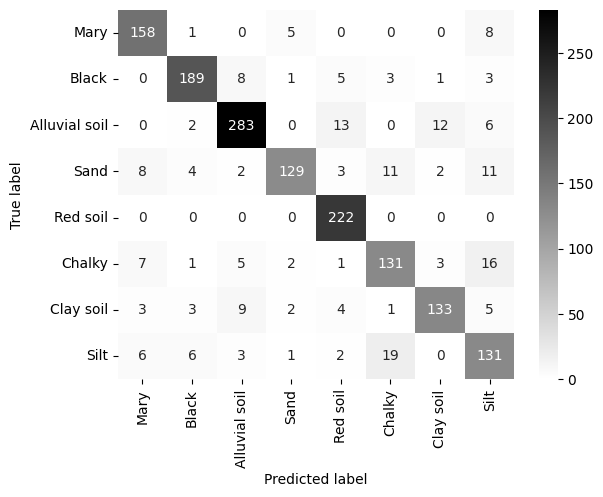

In [20]:
import seaborn as sns
cm = metrics.confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='binary')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(image_dataset.target_names, rotation='vertical')
ax.yaxis.set_ticklabels(image_dataset.target_names, rotation='horizontal')

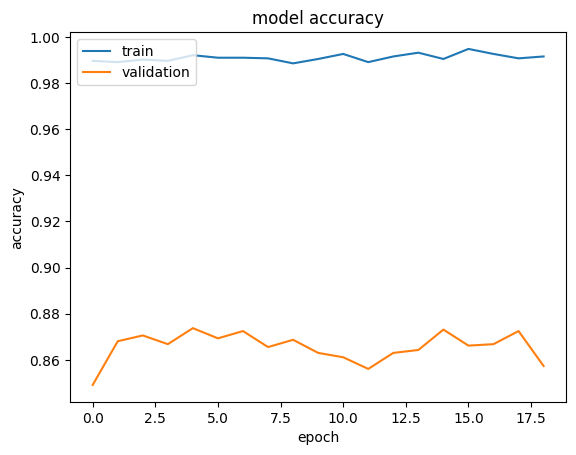

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (6,).

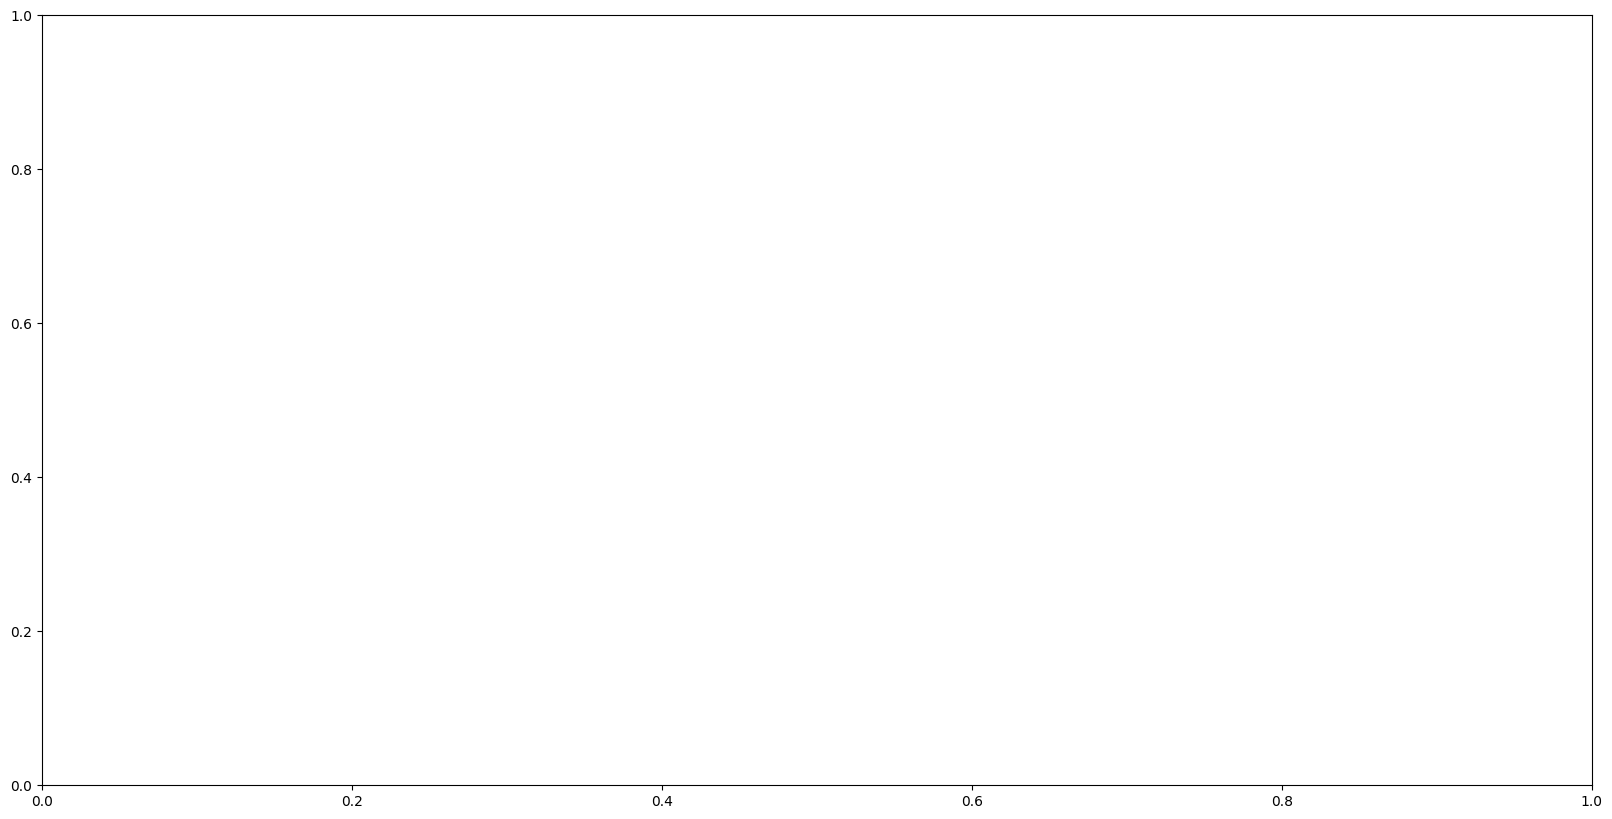

In [24]:
key = ['Accuracy', 'F1-Score']
labels = ['Random Forest','Desicion Tree','KNN','SVM','CNN']
bar_width = 0.35
index = range(len(labels))

fig, ax = plt.subplots(figsize=(20, 10))

bar1 = ax.bar(index, accuracy ,bar_width, label='Accuracy', color='red')
bar2 = ax.bar([i + bar_width for i in index], f1_score, bar_width, label='F1-Score', color='green')

# Display percentage values on top of the bars
for bar in [bar1,bar2]:
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)

plt.ylabel("Score", fontsize=30)
plt.xlabel("Classification Model", fontsize=30)
plt.legend(key, fontsize=26)
plt.title("Experiment 3: Accuracy and F1 Scores", fontsize=34)
plt.ylim((60,100))
plt.tick_params(labelsize=26)
plt.grid()
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.show()

In [ ]:
!pip install keract
from keract import get_activations, display_heatmaps, display_activations
keract_inputs = X_test[0:1]
keract_targets = y_test[0:1]
activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="viridis", directory='Activations/', fig_size=(9, 9))